In [1]:
%load_ext Cython

In [2]:
import networkx as nx
import numpy as np
from operator import itemgetter
def construct():
    g = nx.barabasi_albert_graph(n=500, m=10,seed=2017)

    adjlist = nx.generate_adjlist(g, delimiter=",")
    adjlist = [np.array([eval(x)]).flatten() for x in adjlist]

    lens = [len(x) for x in adjlist]
    maxlen = max(lens)
    n = g.number_of_nodes()
    
    adjlist_m = np.ones([n, maxlen], dtype = np.int32) * (-1)
    for nn in range(n):
        adjlist_m[nn, :lens[nn]] = adjlist[nn]
    
    degree_list = [ [node,degree] for node, degree in g.degree(range(n)).items() ]
    sorted_degrees = sorted(degree_list, key=itemgetter(1), reverse = True)
    
    return sorted_degrees,adjlist_m

sorted_degrees,adjlist_m = construct()

In [57]:
%%cython 
import numpy as np
cimport numpy as np

'''
Ignorant: 0
Spreader: 1
Stifler : 2
'''

cdef _info_spread(np.ndarray[np.int32_t, ndim=2] adjlist_m, \
                np.ndarray[np.int32_t, ndim=1] states):  
    cdef int N = adjlist_m.shape[0]
    cdef int change = 0
    cdef float alpha = 0.4
    cdef float p = 0.2
    cdef float lamda = 0.2
    cdef Py_ssize_t n_i,n_j
    cdef np.ndarray[np.int32_t, ndim=1] new_states = states
    
    for n_i in range(N):
        # the node has been removed
        if adjlist_m[n_i,0] == -1:
            continue
        
        # n_i is not 'S'
        if states[n_i] == 2 or states[n_i] == 0:
            continue 
            
        # n_i is 'S'
        for n_j in adjlist_m[n_i,1:]: 
            # !! Discard Padding
            if n_j == -1:
                continue
            # n_j is 'I'
            if states[n_j] == 0:
                # I-->S
                if np.random.random() < alpha*p:
                    new_states[n_j] = 1
                    change += 1
                # I-->R
                elif np.random.random() < alpha*(1-p):
                    new_states[n_j] = 2
                    change += 1
            # n_j is 'R' or 'S'
            elif np.random.random() < lamda:
                    # S -> R
                    new_states[n_i] = 2
                    change += 1
                    break
            
    return new_states,change


def InfoSpread(adjlist, seeds, nodes_to_rm):
    N = adjlist.shape[0]
    change = 1 
    states = np.zeros(N,dtype=np.int32)
    
    # =================Initialize================
    '''
    rm nodes and set seeds --- Note: Don't set removed nodes as seeds
    '''
    # rm nodes from adjlist <=> set to -1
    for i in nodes_to_rm:
        for nns in adjlist[i,1:]:
            # disconnect i from its nns
            adjlist[nns,:] = np.where(adjlist[nns,:]==i, -1, adjlist[nns,:])
        # disconnect i and its nns
        adjlist[i,:] = -1

    #set seeds
    for seed in seeds:
        states[seed] = 1
    #rm nodes
    for i in nodes_to_rm:
        states[i] = -1
        
    
    #==============iter til converge==============
    while change:
        states,change = _info_spread(adjlist, states)
        
    return states

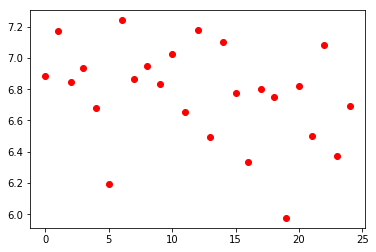

In [62]:
import matplotlib.pyplot as plt

# np.random.seed(2017)

def main_simulate(adjlist, nodes_to_rm):
    N = adjlist.shape[0]
    rm_nodes = []
    Avr_rhos = []
    for i in nodes_to_rm:
        rm_nodes.append(i)
        rho = 0
        for seed in range(N):
            for _ in range(100):
                final_states = InfoSpread(adjlist, [seed], rm_nodes)
                rho += sum(np.where(np.array(final_states) == 2, 1, 0))/N
        rho=rho/500/100
        
        Avr_rhos.append(rho)
        
    plt.plot(range(25), Avr_rhos,'ro')
    plt.show()

if __name__ == '__main__':
    attack_list_k = np.array(sorted_degrees)[:25,0]
    main_simulate(adjlist_m,attack_list_k)

0.5